In [ ]:
using LinearAlgebra, FermionicHilbertSpaces, Revise, Random, Arpack, SparseArrays, Plots, LinearMaps, TestItems, Test, NonCommutativeProducts, Statistics
using Distributions: Normal

includet("..//src//quantum_dot_system.jl")
includet("..//src//states.jl")
includet("..//src//time_evolution.jl")
includet("..//src//measurements.jl")
includet("..//src//effective_measurements.jl")
includet("..//src//hamiltonian_tight_binding.jl")
includet("..//src//scrambling_map.jl")

# QELM Status

# 1. Quantum dot reservoir model

In [ ]:
#Initializing a system of quantum nbr dots
nbr_dots_main, nbr_dots_res, qn_reservoir = 2, 3, 1
qd_system = tight_binding_system(nbr_dots_main, nbr_dots_res, qn_reservoir)

## 1.1 Time- independent Hamiltonian
# 
The total Hamiltonian is the sum of the initial system hamiltonian, reservoir hamiltonian and interaction hamiltonian
$$
    H = H_{0} + H_R + H_I. 
$$
The initial system Hamiltonian and reservoir Hamiltonian describe the intra- and inter-dot terms within the systems by
$$
    H_{0, R} = H_\epsilon + H_B  + H_{U}^{intra} + H_{U}^{inter} + H_t + H_{SO},
$$
while the interaction Hamiltonian include inter-dot interactions between initial system and reservoir
$$
    H_I = H_{U}^{inter} + H_t + H_{SO}.
$$
These terms are described by
$$
\begin{aligned}
& H_\epsilon = \sum_{i, j , \sigma} \epsilon_{ij} c^\dagger_{i, j, \sigma} c_{i, j, \sigma} \\[4pt]

& H_B = \sum_{i, j} \left( c^\dagger_{i, j, \uparrow} c_{i, j, \uparrow} - c^\dagger_{i, j, \downarrow} c_{i, j, \downarrow} \right) \\[4pt]

& H_{U}^{intra} = \sum_{i, j} U_{i,j} c^\dagger_{i,j,\uparrow} c^\dagger_{i,j,\downarrow} c_{i,j,\downarrow} c_{i,j,\uparrow} \\[4pt]

& H_{U}^{inter} = \sum_{i, j, \sigma, \sigma'} U_{(i,j)(i+1,j)} c^\dagger_{i,j,\sigma} c^\dagger_{i+1, j, \sigma'} c_{i+1, j, \sigma'} c_{i,j, \sigma} \\
& \qquad + \sum_{i, j, \sigma, \sigma'} U_{(i,j)(i,j+1)} c^\dagger_{i,j,\sigma} c^\dagger_{i, j+1, \sigma'} c_{i, j+1, \sigma'} c_{i,j, \sigma} \\[4pt]

& H_t = \sum_{i, j, \sigma} t_{(i,j)(i+1,j)} c^\dagger_{i+1,j,\sigma} c_{i,j,\sigma} + h.c. \\
& \qquad + \sum_{i, j, \sigma} t_{(i,j)(i,j+1)} c^\dagger_{i,j+1,\sigma} c_{i,j,\sigma} + h.c. \\

&H_{SO} = -(\sum_{i, j, \sigma, \sigma'} t^{(SO)}_{(i,j)(i+1,j)}c^\dagger_{i+1,j,\sigma}(i\sigma_y)_{\sigma, \sigma'}c_{i,j,\sigma} + h.c \\
& \qquad   -(t^{(SO)}_{(i,j)(i,j+1)}c^\dagger_{i,j+1,\sigma}(i\sigma_x)_{\sigma, \sigma'}c_{i,j,\sigma} + h.c )) 

\end{aligned}

$$
The parameter ranges are randomized from the following distributions:
$$
\begin{aligned}
    &\epsilon_{i, j} = 0.5 \hspace{5mm} \text{for (i,j) in initial system}\\
    &\epsilon_{i, j} \in [0,1] \hspace{5mm} \text{for (i,j) in reservoir} \\
    &\epsilon_\sigma=1 \\
    &U_{i, j}^{intra} \in [10, 11]\\
    &U_{(i, j),(i', j')}^{inter} \in [0,1] \\
    &t_{(i, j),(i', j')}\in[0,1] \\
    &t_{(i, j),(i', j')}^{SO} \in [0, 0.1]
\end{aligned}
$$


In [ ]:
hams = hamiltonians(qd_system)

## 1.2 Quantum states

The state of the initial system, $\rho_0$ is set with one electron per QD. The initial reservoir state, $\rho_R$ is the ground state of $H_R$. Next, the total quantum state can be formed by 
$$
    \rho = \rho_0 \otimes \rho_R.
$$
We get the state at time t by 
$$
    \rho(t) = U_t(\rho_0\otimes \rho_R) U_t^\dagger, \\

    U_t = \exp\{-i Ht\}.
$$

In [ ]:
ind0 = FermionicHilbertSpaces.indices(qd_system.H_main_qn, qd_system.H_main)
indR = FermionicHilbertSpaces.indices(qd_system.qn_reservoir, qd_system.H_reservoir)
indt =  FermionicHilbertSpaces.indices(qd_system.qn_total, qd_system.H_total)
ρ0 = def_state(singlet,qd_system.H_main, qd_system.f)
ρR = ground_state(hams.hamiltonian_reservoir, qd_system.H_reservoir, qd_system.qn_reservoir)
ρ = tensor_product((ρ0, ρR), (qd_system.H_main, qd_system.H_reservoir)=> qd_system.H_total)

## 1.3 Time-dependent Hamiltonian

Simulate a system where we slowly turn on and of the tunneling interactions between the dots? 
$$
    H_{t,SO}(t) = f(t)H_{t,SO}
$$

## 1.4 Particle-hole symmetry and energy spectrum


Results from master thesis show that the reservoir performs worse when there are many electrons in the reservoir. See for example figure \ref{fig:noise_tol} of the noise tolerance with varying electrons in the reservoir. I think we should connect this to the energy spectrum of the system and the parameters of the Hamiltonian. 
<br>

<p align="center">
  <img src="nois_tol_linear5 (1).png" alt="Noise tolerance plot" width="700">
</p>

$\epsilon$ is now set as $\epsilon - U_{intra}/2$ giving a _more_ symmetric energy spectrum

In [ ]:
ham_tot= matrix_representation(hams.hamiltonian_total, qd_system.H_total)
vals, vecs = eigen(Matrix(ham_tot))
plot(vals, seriestype=:scatter)
yaxis!("Eigenenergy")

## 1.5 Decoherence

Include?

## 2.1 Scrambling map

We find the expectation value of a measurement operator $N$ by 
$$
    \braket{N} = tr\{N\rho(t)\} = tr\{NU_t(\rho_0\otimes \rho_R)U_t^\dagger\} = tr\{N(t,\rho_R)\rho_0\} = (N^\dagger(t,\rho_R)|\rho_0)
$$
A vector of expectation values can be found by

$$
    S|\rho_0) = P, \hspace{5mm} S = \begin{bmatrix}
        (N^\dagger_1(t, \rho_R)| \\
        \vdots\\
        (N_N^\dagger(t,\rho_R)|
    \end{bmatrix}, \hspace{5mm} P = \begin{bmatrix}
        \braket{N_1} \\
        \vdots\\
        \braket{N_N}
    \end{bmatrix}.
$$
Here, S is the "scrambling map" describing the linear mapping from the initial system state to the expectation values.

If the measurements are tomographic complete, i.e.at least $d_{sys}^2$ linearly independent measurements, we can find a recovery map, $R$, that reconstructs the initial state from the measurement expectation values. 
$$
    RS = I, \hspace{5mm} RP = |\rho_0)
$$


In [ ]:
t = [3, 4]
measurement_types = charge_probabilities
seed = 1

S = Matrix(scrambling_map(qd_system, t, measurement_types, 1))
ρ0_vec = vec(ρ0[ind0, ind0])

measurements = S*ρ0_vec
print(Vector(measurements))
R = pinv(S)

print(R*measurements ≈ ρ0_vec)

## 2.2 Uncorrelated charge measurements

Probability to measure one and two charges on each dot measured by the operators
$$
    p^{(0)}_{(i,j)} = 1 -n_{(i,j),\uparrow} - n_{(i,j),\downarrow} +n_{(i,j),\uparrow}n_{(i,j),\downarrow},
\\
    p^{(1)}_{(i,j)} = n_{(i,j),\uparrow} + n_{(i,j),\downarrow} -2n_{(i,j),\uparrow}n_{(i,j),\downarrow},
\\
p^{(2)}_{(i,j)} = n_{(i,j),\uparrow}n_{(i,j),\downarrow}
$$

## 2.3 Correlated charge Measurements

By the uncorrelated measurements we measure one dot in the system and then throw away the remaining state. Another option would be to extract more information about the state with many measurements on the same state, without preparing it all over again in the initial system. 

One option is to first measure one observable, giving the post-measurement state   
$$
    \rho_\alpha = \frac{(I\otimes \ket{\alpha}\bra{\alpha}) \rho (I\otimes \ket{\alpha}\bra{\alpha})}{P_\alpha}.
$$
Next, we can evolve this state(?) and measure another observable.  

Another option is to simultaneously measure all observable. This would correspond to measure the probabilities for all combinations of measurement outcomes. For example, the probability for the charge measurement outcome 1, 2, 0 and 1 on the respective each dots is 
$$
    P(1,2,0,1) =tr\{p^{(0)}_{(1,1)}p_{(2,1)}^{(1)}p_{(1,2)}^{(2)}p_{(2,2)}^{(1)}\rho\}
$$

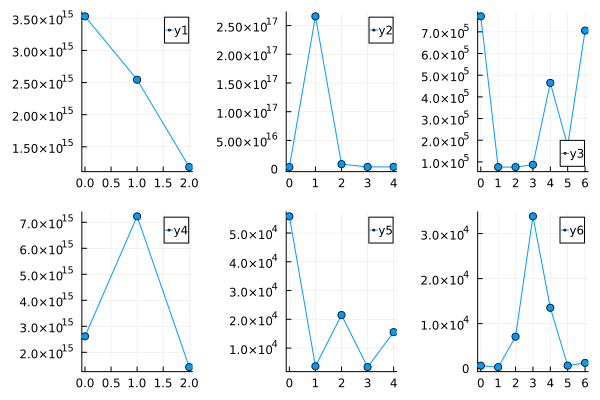

In [ ]:
#Comparing the condition number of correlated and uncorrelated measurements

nbr_dots_res_list = [1, 2,3]
plot_comp = plot(layout = (2,length(nbr_dots_res_list)))
t_list = [10, 20]
seed = 3

measurements = [charge_probabilities, correlated_measurements]
for (j,m) in enumerate(measurements)
    for (i,nbr_dots_res) in enumerate(nbr_dots_res_list)
        qn_reservoir_list = [i for i in 0:nbr_dots_res*2]
        conds = []
        for qn_reservoir in qn_reservoir_list
            qd_system = tight_binding_system(2, nbr_dots_res, qn_reservoir)
            S = scrambling_map(qd_system, t_list, m, seed)
            push!(conds, cond(S))
        end
        plot!(plot_comp[j,i], qn_reservoir_list, conds, markershape=:circle)
    end
end
 
display(plot_comp)

In [19]:
qd_system = tight_binding_system(2, 3, 3)
S = scrambling_map(qd_system, t_list, correlated_measurements, seed)

cond(S)

33831.35034188147

## 2.4 Weak measurements

Include?

## 2.5 Increase number of measurements

Increase number of measurements by time multiplexing or by varying energy levels of hamiltonian. Do we want tomographic completeness?

# 3. Machine learning 

## 3.1 Classification with Support Vector Machines 
Some pros of SVM: 
* Generalization ability
* Fewer parameters to adjust compared to deep learning
* Simple to introduce nonlinearity
* Works well when classes do not overlap 

<br>
<p align="center">
  <img src="SVMmethods4 (1) (1).png" alt="svm plot" width="700">
</p>

## 3.2 Support Vector Regression

## 3.3 Neural Networks

Do we have good reasons for using SVMs? What are the pros/cons? I think we should at least test with neural networks as well and compare. 

# 4. Generating data 

## 4.1 Entangled and separable states
We generate training data by varying noise in entangled states and by sampling separable state from the boundary of separable states. For the linear tasks, we only need to sample the product states, as these are the extreme points of the set of separable states.  For the nonlinear tasks, we need to sample the full boundary of separable states. (Is this reliable?)
<br>
<p align="center">
  <img src="ConvexSets2 (1).png" alt="convex sets" width="700">
</p>

## 4.2 Data for regression tasks

How will we do this? Do we train to predict the property of a specific type of state? Or are we able to sample the whole space of density matrices?

Hilbert Schmidt ensamble: 
1) X - each element is drawn from a normal distribution
2) Project on space of density matrices by $ \frac{XX^\dagger}{trXX^\dagger}$

In [ ]:
# Sample random matrices from a normal distribution
function hilbert_schmidt_ensamble(dim)
    X = (randn(dim, dim) .+ 1im * randn(dim, dim))./sqrt(2)
    ρ = X'X/tr(X'X)
    return ρ
end
ρ = hilbert_schmidt_ensamble(4)
println("Trace: ", round(tr(ρ), digits = 2))
println("Purity: ", round(tr(ρ^2), digits=2))
println("Rank: ", rank(ρ))

## 4.3 Adding Noise

Adding noise measurement outcomes will affect the sampling complexity of both reconstructing $R_O$ and using the found $R_O$ to predict a property of the initial state. 

Two types of noise we can consider: 

### 1. Noise in reconstructed expectation value due to few measurements
Depends on the variance of the measurements (and thus also the initial state): 

$$
Var[p_n] = \langle p_n^2 \rangle - \langle p_n \rangle ^2
$$

$$
\sigma_n^2 = \frac{Var[p_n]}{N_{measurements}} 
$$

One option to model this noise is by sampling an error $\xi_n$ from $\mathcal{N}(0, \sigma_n)$

Another option is to input measurement outcomes instead of expectation values.

### 2. Noise due to apparatus

Can we do similarily?

$\xi_a$ from $\mathcal{N}(0, \sigma_a)$  

How do we set $\sigma_a$? Can we assume that mean error is 0?


## Example

Sample noise by:
$\xi_a$ ~ $\mathcal{N}(0, \sigma_a)$  

Without noise: $M = S|\rho)$ 

Adding noise: $M^{noisy}_{ij} = M_{ij} + \xi_{a, ij}$

In [ ]:
includet("..\\PredictSpin\\predict_spin.jl")

## ======= DEFINE PARAMETERS =========
#Reservoir
nbr_dots_res = 3
nbr_dots_res_list = [1,2,3,4,5]
qn_reservoir =1
seed = 10

#Measurements
#noise_std = 0.001
noise_std_list = 10 .^ range(-7, -1, length= 5)
noise_std_list_long = 10 .^ range(-7, -1, length=30)
t_list = [10, 20, 30]
measurement_type = charge_probabilities
op = (σx, σy)

#Training and test
nbr_states = 2*10000
regularization = 0
nbr_states_train = nbr_states ÷ 2
## ======================================

states = get_states(nbr_states)
qd_system, S = get_S(nbr_dots_res, qn_reservoir, t_list, seed, measurement_type)

function plot_predictions!(states, qd_system, S, op, noise_std, ax)
    op_vec, spin_exp_val, charge_exp_val = measure_spin_charge(states, qd_system, S, op, noise_std)
    X_train, X_test, Y_train, Y_test = transform_data(spin_exp_val, charge_exp_val, nbr_states_train)
    W = ridge_regression(X_train, Y_train, regularization)

    Y_test_pred = X_test*W
    idx_sort = sortperm(Y_test)
    Y_pred_sorted = Y_test_pred[idx_sort]
    Y_true_sorted = Y_test[idx_sort]
    mse = mean((Y_test -Y_test_pred).^2)
    plot!(ax, Y_true_sorted[1:50:end], seriestype=:scatter, label="True",title = "σₐ = $noise_std, mse = $(mse)")
    plot!(ax, Y_pred_sorted[1:50:end], seriestype=:scatter, label="Pred")
end

plt = plot(layout = (length(noise_std_list), 1), size=(700, 1000))
for (i, noise_std) in enumerate(noise_std_list)
    plot_predictions!(
        states, qd_system, S, op, noise_std, plt[i]
    )
end
display(plt)

## =======================
function prediction_mse(states, qd_system, S, op, noise_std)
    op_vec, spin_exp_val, charge_exp_val = measure_spin_charge(states, qd_system, S, op, noise_std)
    X_train, X_test, Y_train, Y_test = transform_data(spin_exp_val, charge_exp_val, nbr_states_train)
    W = ridge_regression(X_train, Y_train, regularization)
    Y_test_pred = X_test*W
    mse = mean((Y_test -Y_test_pred).^2)
    return mse
end

plt2 = plot(xlabel = "σₐ", ylabel = "MSE",  xaxis=:log, legend=:topleft)
for nbr_dots_res_i in nbr_dots_res_list
    qd_system_i, S_i = get_S(nbr_dots_res_i, qn_reservoir, t_list, seed, measurement_type)
    mse_list = [prediction_mse(states, qd_system_i, S_i, op, noise_std) for noise_std in noise_std_list_long] 
    plot!(plt2, noise_std_list_long, mse_list, label = "Nbr. dots: $(nbr_dots_res_i), Cond. nbr.: $(round(cond(S_i), digits = 0))")
end
display(plt2)

In [ ]:
qd_s1, S_1 = get_S(nbr_dots_res, qn_reservoir, t_list, 1, measurement_type)
qd_s2, S_2 = get_S(nbr_dots_res, qn_reservoir, t_list, 2, measurement_type)

println(cond(S_1))
println(cond(S_2))


# 5.Performance measures

## 5.1 Prediction Accuracy 

One option to measure the performance ability of the model for a specific task. This could be a mean squared error for a regression task. For the entanglement witnesses we measured the performance in terms of noise tolerance. 

## 5.2 Noise tolerance and Sample complexity

We want to look further on how tolerant our model is to noise in measurements. Here it could be both noise in measurement instruments and noise due to few measurements. One way of analyzing this is by the condition number of the scrambling map. Here we should understand better what the condition number means for our model. 

<br>
<p align="center">
  <img src="condition_numbers2 (1).png" alt="condnbr" width="500">
</p>



## 5.3 Information Scrambling

How well is information scrambling over the system? 
What is the scrambling time? 
What measures can we have for this? 

See for example how the condition number of the scrambling map decreases with time: 

<br>
<p align="center">
  <img src="cond_number_S (1).png" alt="condnbr" width="500">
</p>

# 6. Tasks

* Classification tasks
* Regression tasks
* Linear tasks
* Nonlinear tasks

# 6.1 Entanglement witnesses

We can use this method to find entanglement witnesses for the Bell states. Moreover, we have seen that this many times work when the measurements are __tomographic incomplete__. 
<br>
<p align="center">
  <img src="LinearP (1) (1).png" alt="ewl" width="500">
</p>

We can implement nonlinear EWs that can classify all Bell states as entangled with a single EW. 
<br>
<p align="center">
  <img src="NonlinearEWP (1) (1).png" alt="ewn" width="500">
</p>

## 6.2 Linear regression - predict single dot spin
If we know the recovery map, R, we can find the expectation value of an operator o from the charge measurements N by: 

$$
    \rho_0 = RN \\
    \langle o \rangle = (o^\dagger |\rho_0) = (o^\dagger | R N  = R_O N \\
    R_O = (o^\dagger | R
$$

If we  dont know $R_O$, we can learn it by linear regression

$$
    \tilde{N} = [N^{(1)}, ....., N^{(N_{train})}], \tilde{o} = [\langle o^{(1)} \rangle, ....., \langle o^{(N_{train})} \rangle ]  \\
    R_O \tilde{N} = \tilde{o} \\

    R_O \approx \tilde{o}\tilde{N}^+
$$

We can now use $R_O$ to predict the expectation value of O from charge measurements in a test dataset

$$
    \langle o^{(m)} \rangle_{pred} = R_O N^{(m)}
$$

We can evaluate the model by the mean squared error of the predicted spin

$$
MSE(o) = \frac{1}{N_{test}}\sum_{m=1}^{N_{test}} (\langle o^{(m)} \rangle - \langle o^{(m)} \rangle_{pred})^2
$$

Moreover, we test if the found weigts from linear regression converges to $R_O$ constructed by inversion of the scrambling map:  

$$
MSE(R_O) = ||(o^\dagger|R-W||_2^2
$$


In [ ]:
includet("..//PredictSpin//ridge_regression.jl")
nbrs = range(10, 200, 50)
op = (σx, σy)
predictions = [predict_spin(nbr, op) for nbr in nbrs]
mse_test_list = getindex.(predictions, 2)
op_diff_list = getindex.(predictions, 3)
plot(nbrs .÷ 2, mse_test_list, ls=:dot, yaxis=:log, xlabel = "Number states in training data", ylabel = "MSE", label = "MSE of spin prediction",legendfont=font(10))
plot!(nbrs .÷ 2, op_diff_list, label = "MSE of reconstructing R_O")

## 6.3 Nonlinear regression tasks

Can we estimate a __nonlinear function__ of the state? Do we need multiple copies? 